In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import mlflow
import mlflow.sklearn
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanAbsoluteError

In [2]:
# Load the Rossmann Store Sales dataset from the specified path
data_path = 'C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/Rossmann_Sales_Forecasting_Project/data/synthetic_sales_data.csv'
data = pd.read_csv(data_path)

# Check column names in the DataFrame
print("Columns in the DataFrame:", data.columns)

# Ensure that the 'Date' column exists (correct case)
if 'Date' in data.columns:
    # Convert the 'Date' column to datetime format
    data['Date'] = pd.to_datetime(data['Date'])
else:
    raise KeyError("The 'Date' column is missing from the dataset.")

Columns in the DataFrame: Index(['Date', 'Store', 'Store_Type', 'Store_Status', 'Promo', 'Promo2',
       'School_Holiday', 'Customers', 'Sales'],
      dtype='object')


In [3]:
# Task 2.1: Feature extraction
data['weekday'] = data['Date'].dt.weekday  # Extract weekday (0=Monday, 6=Sunday)
data['is_weekend'] = (data['weekday'] >= 5).astype(int)  # Mark weekends
data['days_to_holiday'] = (pd.to_datetime('2024-12-25') - data['Date']).dt.days  # Days to next holiday
data['days_after_holiday'] = (data['Date'] - pd.to_datetime('2024-12-25')).dt.days.clip(lower=0)  # Days since last holiday
data['is_beginning_of_month'] = (data['Date'].dt.day <= 7).astype(int)  # Is beginning of the month
data['is_mid_month'] = ((data['Date'].dt.day > 7) & (data['Date'].dt.day <= 14)).astype(int)  # Is mid-month
data['is_end_of_month'] = (data['Date'].dt.day > 14).astype(int)  # Is end of the month

# Handle NaN values by filling them with zeros
data.fillna(0, inplace=True)

In [4]:
# Task 2.1: Prepare features and target variable
X = data.drop(columns=['Sales', 'Date'], errors='ignore')  # Features (exclude target and date)
y = data['Sales']  # Target variable

# Task 2.1: Handle categorical variables using OneHotEncoder
categorical_features = ['Store_Type', 'Store_Status']  # Add categorical features to encode
numerical_features = ['weekday', 'days_to_holiday', 'days_after_holiday']  # Select numerical features to scale

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


In [5]:
# Apply the preprocessing
X = preprocessor.fit_transform(X)

In [6]:
# Task 2.2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split dataset



In [7]:
# Task 2.3: Choose a loss function
loss_function = MeanAbsoluteError()  # Define the loss function
print("Loss Function Selected: Mean Absolute Error")

# Start MLflow experiment tracking
mlflow.start_run()

# Log parameters, metrics, and model version
mlflow.log_param("model_type", "RandomForestRegressor")
mlflow.log_param("n_estimators", 100)
mlflow.log_param("loss_function", "Mean Absolute Error")


Loss Function Selected: Mean Absolute Error


'Mean Absolute Error'

In [8]:
# Task 2.4: Create and fit the Random Forest model using a pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # Initialize RandomForestRegressor
])

pipeline.fit(X_train, y_train)  # Fit the model to the training data



Pipeline(steps=[('regressor', RandomForestRegressor(random_state=42))])

In [9]:
# Task 2.4: Make predictions using the model
y_pred = pipeline.predict(X_test)  # Predict on test set

# Task 2.4: Post Prediction Analysis
# Evaluate model performance using the chosen loss function
mae = loss_function(y_test, y_pred)  # Calculate Mean Absolute Error
print(f'Mean Absolute Error: {mae.numpy()}')  # Output the MAE

# Log the MAE metric
mlflow.log_metric("mae", mae.numpy())


Mean Absolute Error: 382.65203857421875


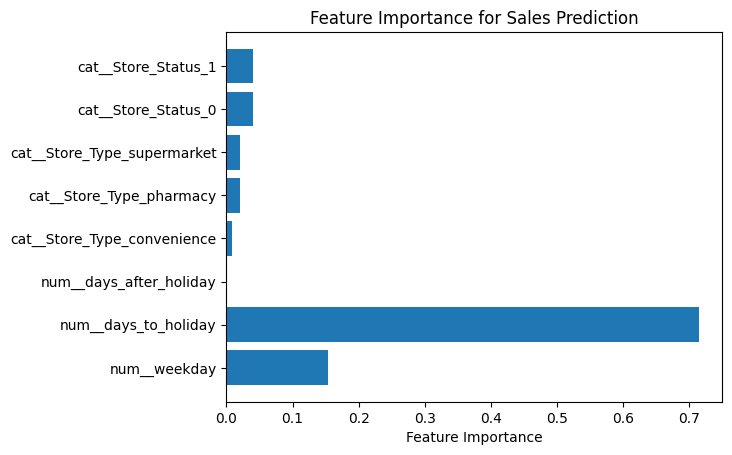

In [10]:
# Explore feature importance
importance = pipeline.named_steps['regressor'].feature_importances_  # Get feature importance
features = preprocessor.get_feature_names_out()  # Get feature names after transformation

# Plot feature importance
plt.barh(features, importance)  # Create horizontal bar plot for feature importance
plt.xlabel('Feature Importance')  # Label for x-axis
plt.title('Feature Importance for Sales Prediction')  # Title for the plot
plt.show()  # Show the plot

In [11]:
# Estimate confidence intervals for predictions
confidence_interval = 1.96 * np.std(y_pred) / np.sqrt(len(y_pred))  # 95% confidence interval
print(f'95% Confidence Interval for Predictions: +/- {confidence_interval:.2f}')

95% Confidence Interval for Predictions: +/- 11.96


In [12]:
# Task 2.5: Serialize the Random Forest model
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")  # Create timestamp for file name
model_directory = 'C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/Rossmann_Sales_Forecasting_Project/models/saved_models'  # Directory for saving models

# Create the models directory if it does not exist
if not os.path.exists(model_directory):
    os.makedirs(model_directory)  # Create the directory

model_filename = f'{model_directory}/random_forest_model_{timestamp}.pkl'  # File path for saving the model
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)  # Save the model using pickle
print(f'Model saved as: {model_filename}')

# Log the RandomForest model to MLflow
mlflow.sklearn.log_model(pipeline, "random_forest_model")

Model saved as: C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/Rossmann_Sales_Forecasting_Project/models/saved_models/random_forest_model_15-11-2024-13-32-11.pkl


2024/11/15 13:32:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [13]:
# Task 2.5.1: Save the MinMaxScaler model
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y.values.reshape(-1, 1))  # Fit the scaler on target variable

scaler_filename = f'{model_directory}/minmax_scaler_{timestamp}.pkl'  # File path for saving the scaler model
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)  # Save the scaler using pickle
print(f'MinMaxScaler saved as: {scaler_filename}')

# Log the MinMaxScaler model to MLflow
mlflow.log_artifact(scaler_filename)

MinMaxScaler saved as: C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/Rossmann_Sales_Forecasting_Project/models/saved_models/minmax_scaler_15-11-2024-13-32-11.pkl


In [14]:
# Task 2.6: Deep Learning - LSTM Model
data['Sales'] = data['Sales'].astype(float)  # Ensure sales data is float

In [15]:
# Task 2.6.1: Check stationarity with Augmented Dickey-Fuller test
adf_test = adfuller(data['Sales'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] > 0.05:
    print("Time series is not stationary. Differencing the data...")
    data['sales_diff'] = data['Sales'].diff().fillna(0)  # Difference the data to make it stationary
else:
    print("Time series is stationary.")
    data['sales_diff'] = data['Sales']  # No differencing needed

ADF Statistic: -61.23057134910118
p-value: 0.0
Time series is stationary.


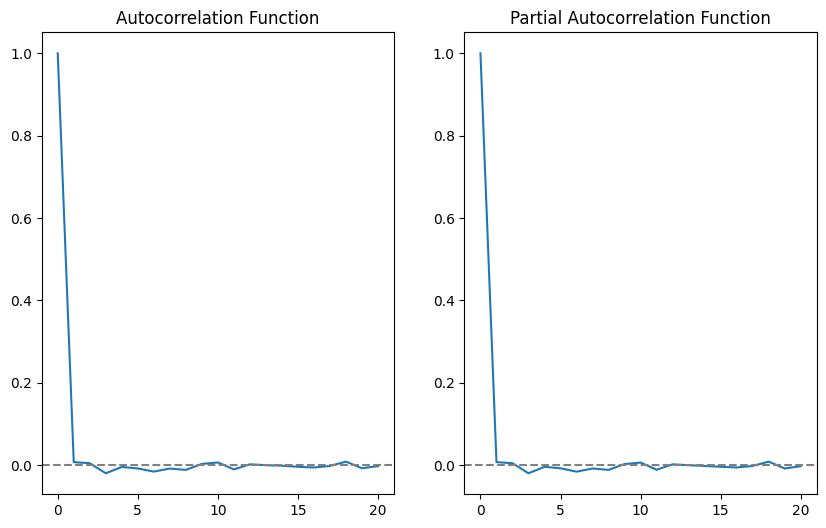

In [16]:
# Task 2.6.2: Autocorrelation and Partial Autocorrelation
lag_acf = acf(data['sales_diff'], nlags=20)
lag_pacf = pacf(data['sales_diff'], nlags=20)

# Plot ACF
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()


In [17]:
# Task 2.6.5: Transform the time series data into supervised learning data
def create_dataset(data, time_step=1):
    X, Y = [], []  # Initialize lists for features and target
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

time_step = 20  # Use last 20 days' data for prediction
X, y = create_dataset(data['sales_diff'].values, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [18]:
# Task 2.6.6: Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))  # LSTM layer
model.add(LSTM(50, return_sequences=False))  # Second LSTM layer
model.add(Dense(1))  # Output layer

model.compile(loss='mean_squared_error', optimizer='adam')  # Compile model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)  # Train model

# Make predictions using the trained LSTM model
y_pred_lstm = model.predict(X_test)
print(f'LSTM predictions: {y_pred_lstm[:5]}')  # Print first 5 predictions

# Save the LSTM model
lstm_model_filename = f'{model_directory}/lstm_model_{timestamp}.h5'
model.save(lstm_model_filename)
print(f'LSTM model saved as: {lstm_model_filename}')

# End MLflow run
mlflow.end_run()

c:\Users\hayyu.ragea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 298743.3750
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 291689.6250
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 280449.5000
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 278650.8750
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 275215.2188
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 266166.1250
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 260968.9531
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 253597.9375
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 240063.3906
Epoch 10/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 247973.4219
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


LSTM predictions: [[130.81438]
 [130.81438]
 [130.81438]
 [130.81439]
 [130.81439]]
LSTM model saved as: C:/Users/hayyu.ragea/AppData/Local/Programs/Python/Python312/Rossmann_Sales_Forecasting_Project/models/saved_models/lstm_model_15-11-2024-13-32-11.h5
